# Two task network 

Network has eight inputs:

1. The fixation. 
1. $u_{rule}^{1}$
1. $u_{rule}^{2}$
1. The first context mod. 
1. The second ontext mod. 
1. The first context status. 
1. The second context status. 
1. The Romo signals.

Network has five outputs: 
1. The fixation. 
1. The first context output. 
1. The second context output. 
1. The first Romo task output. 
1. The second Romo task output. 


<div>
<img src="./images/Sheme.png" width="300"/>
</div>

> Learning rule: superspike

> Neuron type: Alif

In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt  # for analys
from cgtasknet.net.lif import SNNLif
from cgtasknet.tasks.reduce import MultyReduceTasks
from norse.torch.functional.lif import LIFParameters

# from norse.torch import LIF


## Step -1: Create dataset

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('cpu')
print(f'Device: {("gpu (cuda)" if device.type=="cuda" else "cpu")}')

Device: gpu (cuda)


In [3]:
batch_size = 100
number_of_tasks = 1
#tasks = dict(task_list)
tasks = ['DMTask1', 'DMTask2', 'RomoTask']
Task = MultyReduceTasks(tasks=tasks, batch_size=batch_size)
Task_test = MultyReduceTasks(tasks=tasks, batch_size=1)

## Step 1.1: Create model

In [4]:
feature_size, output_size = Task.feature_and_act_size
hidden_size = 400

neuron_parameters = LIFParameters(
    alpha=torch.as_tensor(50), method="super", v_th=torch.as_tensor(0.65).to(device)
)
model = SNNLif(
    feature_size,
    hidden_size,
    output_size,
    neuron_parameters=neuron_parameters,
    tau_filter_inv=500,
).to(device)


## Step 1.2: Save pre-learning weights

In [5]:
weights_pre_l = []
with torch.no_grad():
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_pre_l.append((param).cpu().numpy())

## Step 2: loss and creterion 

In [6]:
learning_rate = 1e-4


class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()

    def forward(self, yhat, y):
        return torch.sqrt(self.mse(yhat, y))


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

## Step 3: Train loop

In [7]:
%matplotlib
plt.ion
fig = plt.figure()
ax = fig.add_subplot(111)

ax.set_title("lif")
inputs, target_outputs = Task.dataset(number_of_tasks)
(line1,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line2,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
(line3,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 1], "b-")
(line4,) = ax.plot(np.arange(0, len(target_outputs)), target_outputs[:, 0, 2], "r-")
ax.set_ylim([-0.5, 1.5])
ax.set_xlim([0, len(inputs)])
running_loss = 0
fig.canvas.draw()
fig.canvas.flush_events()
for i in range(2000):
    inputs, target_outputs = Task.dataset(number_of_tasks)
    #inputs = inputs * 2 - 1
    inputs += np.random.normal(0, 0.01, size=(inputs.shape))
    inputs = torch.from_numpy(inputs).type(torch.float).to(device)
    target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device) 
    #with torch.no_grad():
    #    inputs[:, :, 1:3] = layer_inputs(inputs[:, :, 1:3])[0]
    # zero the parameter gradients
    optimizer.zero_grad()

    # forward + backward + optimize
    outputs, states = model(inputs)

    loss = criterion(outputs, target_outputs)
    loss.backward()
    optimizer.step()

    # print statistics
    running_loss += loss.item()
    if i % 10 == 9:
        print("epoch: {:d} loss: {:0.5f}".format(i + 1, running_loss / 10))
        running_loss = 0.0
        with torch.no_grad():
            inputs, target_outputs = Task_test.dataset(number_of_tasks)

            inputs = torch.from_numpy(inputs).type(torch.float).to(device)
            target_outputs = (
                torch.from_numpy(target_outputs).type(torch.float).to(device)
            )
            outputs, states = model(inputs)
            loss = criterion(outputs, target_outputs)

            print("test loss: {:0.5f}".format(loss.item()))
        for_plot = outputs.detach().cpu().numpy()[:, 0, :]
        line1.set_xdata(np.arange(0, len(for_plot), 1))
        line2.set_xdata(np.arange(0, len(for_plot), 1))
        line3.set_xdata(np.arange(0, len(for_plot), 1))
        line4.set_xdata(np.arange(0, len(for_plot), 1))

        line1.set_ydata(for_plot[:, 1])
        line2.set_ydata(for_plot[:, 2])
        line3.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 1])
        line4.set_ydata(target_outputs.detach().cpu().numpy()[:, 0, 2])
    fig.canvas.draw()
    fig.canvas.flush_events()
print("Finished Training")

Using matplotlib backend: TkAgg
epoch: 10 loss: 0.36776
test loss: 0.37891
epoch: 20 loss: 0.34327
test loss: 0.33274
epoch: 30 loss: 0.31904
test loss: 0.31278
epoch: 40 loss: 0.29371
test loss: 0.27088
epoch: 50 loss: 0.26965
test loss: 0.25692
epoch: 60 loss: 0.26588
test loss: 0.21549
epoch: 70 loss: 0.25326
test loss: 0.28363
epoch: 80 loss: 0.20759
test loss: 0.23367
epoch: 90 loss: 0.17075
test loss: 0.19809
epoch: 100 loss: 0.15417
test loss: 0.24160
epoch: 110 loss: 0.12310
test loss: 0.10871
epoch: 120 loss: 0.11638
test loss: 0.11851
epoch: 130 loss: 0.10788
test loss: 0.10264
epoch: 140 loss: 0.10997
test loss: 0.11655
epoch: 150 loss: 0.10194
test loss: 0.09757
epoch: 160 loss: 0.09991
test loss: 0.09276
epoch: 170 loss: 0.09640
test loss: 0.08345


KeyboardInterrupt: 

In [ ]:
if False:
    torch.save(model.state_dict(), "Only_dm_lif_net")

In [ ]:
if False:
    model.load_state_dict(
        torch.load("Only_dm_lif_net")
    )

In [ ]:
Taskplot = MultyReduceTasks(tasks=tasks, batch_size=1)
inputs, target_outputs = Taskplot.dataset(10)
inputs += np.random.normal(0, 0.01, size=(inputs.shape))
inputs = torch.from_numpy(inputs).type(torch.float).to(device)
target_outputs = torch.from_numpy(target_outputs).type(torch.float).to(device)
outputs, states = model(inputs)

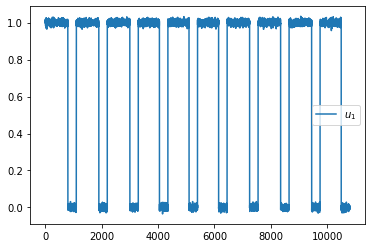

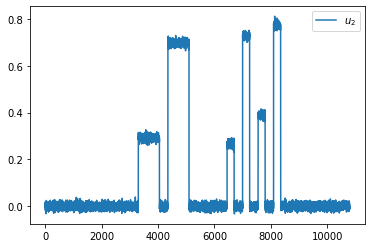

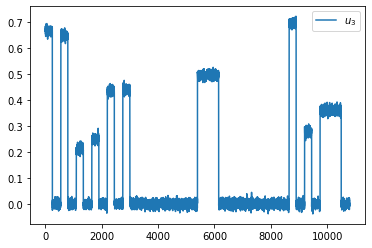

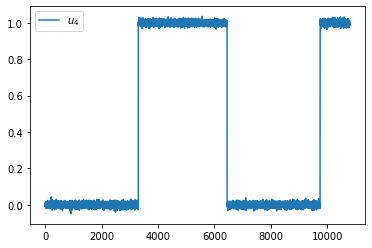

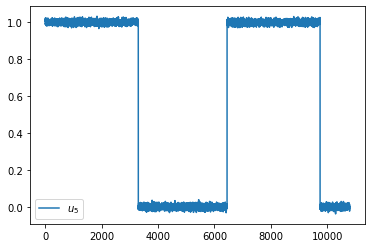

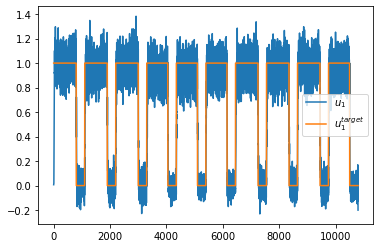

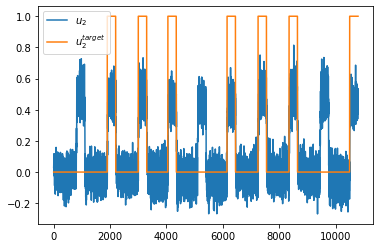

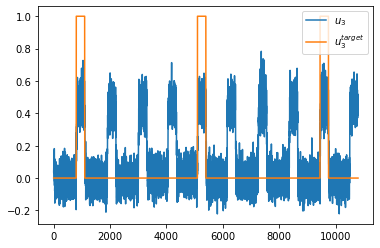

In [ ]:
%matplotlib inline
for i in range(inputs.shape[2]):
    plt.plot(inputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")
    plt.legend()
    plt.show()
    plt.close()
for i in range(outputs.shape[2]):
    plt.plot(outputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")
    plt.plot(
        target_outputs[:, 0, i].detach().cpu().numpy(), label=fr"$u^{{target}}_{i + 1}$"
    )
    plt.legend()
    plt.show()
    plt.close()

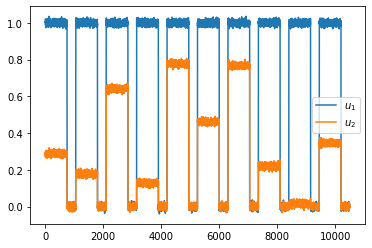

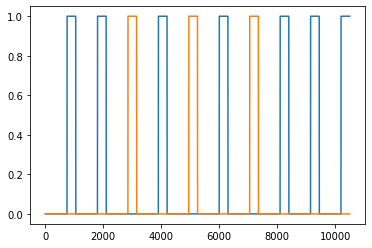

In [ ]:
%matplotlib inline
for i in range(inputs.shape[2]):
    plt.plot(inputs[:, 0, i].detach().cpu().numpy(), label=fr"$u_{i + 1}$")

plt.legend()
plt.show()
plt.close()
plt.plot(target_outputs[:, 0, 1].detach().cpu().numpy(), label=fr'$y_{2}$')
plt.plot(target_outputs[:, 0, 2].detach().cpu().numpy(), label=fr'$y_{3}$')

In [ ]:
weights_post_l = []
with torch.no_grad():
    for name, param in model.named_parameters():
        if param.requires_grad:
            weights_post_l.append((param).cpu().numpy())

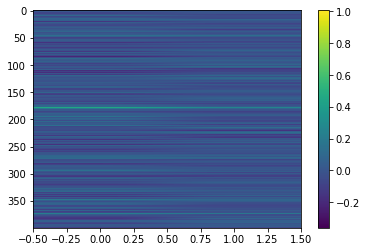

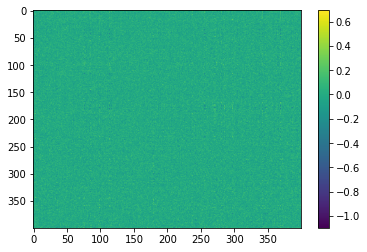

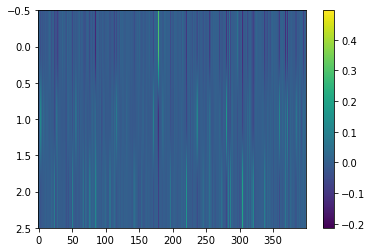

TypeError: Invalid shape (3,) for image data

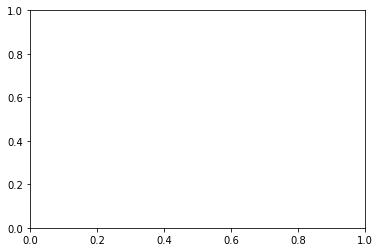

In [ ]:
%matplotlib inline
for i in range(len(weights_pre_l)):
    plt.imshow((weights_post_l[i]), aspect='auto',)
    plt.colorbar()
    plt.show()